In [1]:
from bt import BT
from Elo import ELO
from TrueSkill import TrueSkill

from tqdm import tqdm
import itertools
import os
import json
from collections import defaultdict
import itertools
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
import seaborn as sns

In [2]:
import matplotlib
import matplotlib.font_manager as font_manager
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
fontpath = os.path.expanduser('~/Downloads/LinLibertine_DRah.ttf')
prop = font_manager.FontProperties(fname=fontpath)

fontsize_increase = 2
params = {
    "axes.titlesize" : 18 + fontsize_increase,
    'axes.labelsize': 16 + fontsize_increase,
    'font.size': 18 + fontsize_increase,
    'legend.fontsize': 16 + fontsize_increase,
    'xtick.labelsize': 14 + fontsize_increase,
    'ytick.labelsize': 14 + fontsize_increase,
    'font.family': prop.get_name(),
    'text.usetex': True
}

mpl.rcParams.update(params)

In [3]:
color_mean_med = "#E04644"
color_mean_bt = "#3c4655"
color_med_bt = "#A1CFDD"

## Data Loading

In [4]:
def read_json(file_name):
    filepath = os.path.join(BASE_, file_name)
    with open(filepath, 'r') as f:
        return json.loads(f.read())

In [5]:
def get_metric(merged_datasets, agg_type='union'):
    metrics = []
    for _, dataset in merged_datasets.items():
        metrics.append(set(dataset.keys()))
    if agg_type == 'intersection':
        return set.intersection(*metrics)
    return set.union(*metrics)

In [8]:
with open('Data/Captioning_dataframe.pickle', 'rb') as f:
    caption_df = pickle.loads(f.read())

with open('Data/SUMM_dataframe.pickle', 'rb') as f:
    summ_df = pickle.loads(f.read())

with open('Data/MT_dataframe.pickle', 'rb') as f:
    mt17_df = pickle.loads(f.read())

with open('Data/MT-18_dataframe.pickle', 'rb') as f:
    mt18_df = pickle.loads(f.read())

with open('Data/MT-19_dataframe.pickle', 'rb') as f:
    mt19_df = pickle.loads(f.read())
    
with open('Data/TAC_dataframe.pickle', 'rb') as f:
    tac_df = pickle.loads(f.read())
    
with open('Data/Dialogue_dataframe.pickle', 'rb') as f:
    dial_df = pickle.loads(f.read()) 

In [9]:
merged_datasets =  {} 
merged_datasets['SUMM'] = summ_df['SUMM']
merged_datasets['Captioning'] = caption_df['Captioning']
for k, d in mt17_df['MT'].items():
    merged_datasets['MT-17-{}'.format(k)] = d
for k, d in mt18_df['MT'].items():
    merged_datasets['MT-18-{}'.format(k)] = d
for k, d in mt19_df['MT'].items():
    merged_datasets['MT-19-{}'.format(k)] = d
for k, d in tac_df['TAC'].items():
    merged_datasets['SUMM-{}'.format(k)] = d
for k, d in dial_df['Dialogue'].items():
    merged_datasets['Dialogue-{}'.format(k)] = d

In [10]:
metrics_list = get_metric(merged_datasets, agg_type='union')

In [11]:
all_eval = 0
all_setups = 0
all_pairwise_comparison = 0
for d, k in merged_datasets.items():
    all_setups += len(k)
    all_eval += list(k.values())[0].shape[0]
    for m, df in k.items():
        all_pairwise_comparison += len(list(itertools.combinations(df.columns, 2)))
print("Number of setups: {}".format(all_setups))
print("Number of evaluation: {}".format(all_eval))
print("Number of pairwise comparisons: {}".format(all_pairwise_comparison))

Number of setups: 296
Number of evaluation: 91197
Number of pairwise comparisons: 73471


## Utils

In [12]:
def dataset_to_df(dataset):
    systems = defaultdict(list)
    lst_keys = list(dataset.values())[0]['annotations'][0].keys()
    print(lst_keys)
    tgt = 'pyr_score'
    if tgt not in lst_keys:
        tgt = 'responsiveness'

    for topic, topic_info in dataset.items():
        for a in topic_info['annotations']:
            if a['summ_id'] not in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']:
                systems[a['summ_id']].append(a[tgt])
    return pd.DataFrame.from_dict(systems)

In [13]:
def tau_to_percent(tau):
    return (tau + 1.) / 2.

In [14]:
def same_top_n(lst_a, lst_b,  n=3):
    top_a = np.argsort(-np.array(lst_a))[:n]
    top_b = np.argsort(-np.array(lst_b))[:n]
    return set(top_a) == set(top_b)

In [18]:
def analyze_dataset(df):
    skew, spread, exch = average_skewness(df)
#     print("\tSkew: {} +- {}".format(np.mean(skew), stats.sem(skew)))
#     print("\tSpread: {} +- {}".format(np.mean(spread), stats.sem(spread)))
#     print("\tExchangeability: {} +- {}".format(np.mean(exch), stats.sem(exch)))
    mean_scores = df.mean(axis=0).to_list()
    median_scores = df.median(axis=0).to_list()
    bt_scores = BT(df)
    
    
    print('\tKendall tau [Mean-median]: {}'.format(tau_to_percent(stats.kendalltau(mean_scores, median_scores)[0])))
    print('\tKendall tau [Mean-bt]: {}'.format(tau_to_percent(stats.kendalltau(mean_scores, bt_scores)[0])))
    print('\tKendall tau [bt-median]: {}'.format(tau_to_percent(stats.kendalltau(bt_scores, median_scores)[0])))

    n_s = [1, 2, 3]
    for n in n_s:
        print('\tSOA top {} are the same [mean-median]: {}'.format(n, same_top_n(mean_scores, median_scores, n)))
        print('\tSOA top {} are the same [bt-median] {}'.format(n, same_top_n(bt_scores, median_scores, n)))
        print('\tSOA top {} are the same [mean-bt] {}'.format(n, same_top_n(mean_scores, bt_scores, n)))

## Table 1 (Global Disagreement)

In [19]:
def global_impact_table_1(datasets):    
    data = defaultdict(list)
    for dataset_key, dataset in datasets.items():
        for metric_name, df in tqdm(dataset.items()):
            mean_scores = df.mean(axis=0).to_list()
            median_scores = df.median(axis=0).to_list()
            bt_scores = BT(df)
            
            data['mean_med_disagree'].append(1 - tau_to_percent(stats.kendalltau(mean_scores, median_scores)[0]))
            data['mean_bt_disagree'].append(1 - tau_to_percent(stats.kendalltau(mean_scores, bt_scores)[0]))
            data['med_bt_disagree'].append(1 - tau_to_percent(stats.kendalltau(bt_scores, median_scores)[0]))

            data['mean_med_soa'].append(1 - same_top_n(mean_scores, median_scores, 1))
            data['mean_bt_soa'].append(1 - same_top_n(mean_scores, bt_scores, 1))
            data['med_bt_soa'].append(1 - same_top_n(bt_scores, median_scores, 1))

            data['mean_med_soa-3'].append(1 - same_top_n(mean_scores, median_scores, 3))
            data['mean_bt_soa-3'].append(1 - same_top_n(mean_scores, bt_scores, 3))
            data['med_bt_soa-3'].append(1 - same_top_n(bt_scores, median_scores, 3))
            
    return pd.DataFrame.from_dict(data)

In [20]:
def global_impact_subsampling(datasets, n_repeat=100, percent_subsampling=0.2, method='BT'):
    # Subsampling to mimick the 20% use of dataset for test set.
    skew, spread, exch = [], [], []
    mean_bt_disagree, med_bt_disagree, mean_med_disagree = [], [], []
    mean_bt_soa, med_bt_soa, mean_med_soa = [], [], []
    
    data = defaultdict(list)
    for _ in tqdm(range(n_repeat)):
        dataset_key = random.choice(list(datasets.keys()))
        dataset = datasets[dataset_key]
            
        metric_name = random.choice(list(dataset.keys()))
        df = dataset[metric_name].sample(frac=percent_subsampling)
        
        mean_scores = df.mean(axis=0).to_list()
        median_scores = df.median(axis=0).to_list()
        
#         if method == 'BT':
        bt_scores = BT(df)
#         elif method == 'ELO':
        elo_scores = ELO(df)
#         else:
        ts_scores = TrueSkill(df)
    
        skew_, spread_, exch_, corr_ = average_skewness(df)
        data['skew'].append(np.mean(skew_))
        data['spread'].append(np.mean(spread_))
        data['exch'].append(np.mean(exch_))
        data['corr'].append(np.mean(corr_))
        
        data['mean_med_disagree'].append(1 - tau_to_percent(stats.kendalltau(mean_scores, median_scores)[0]))
        data['mean_bt_disagree'].append(1 - tau_to_percent(stats.kendalltau(mean_scores, bt_scores)[0]))
        data['med_bt_disagree'].append(1 - tau_to_percent(stats.kendalltau(bt_scores, median_scores)[0]))
        
        data['mean_med_soa'].append(1 - same_top_n(mean_scores, median_scores, 1))
        data['mean_bt_soa'].append(1 - same_top_n(mean_scores, bt_scores, 1))
        data['med_bt_soa'].append(1 - same_top_n(bt_scores, median_scores, 1))
        
        data['mean_med_soa-3'].append(1 - same_top_n(mean_scores, median_scores, 3))
        data['mean_bt_soa-3'].append(1 - same_top_n(mean_scores, bt_scores, 3))
        data['med_bt_soa-3'].append(1 - same_top_n(bt_scores, median_scores, 3))
        
        data['mean_elo_disagree'].append(1 - tau_to_percent(stats.kendalltau(mean_scores, elo_scores)[0]))
        data['med_elo_disagree'].append(1 - tau_to_percent(stats.kendalltau(elo_scores, median_scores)[0]))
        
        data['mean_elo_soa'].append(1 - same_top_n(mean_scores, elo_scores, 1))
        data['med_elo_soa'].append(1 - same_top_n(elo_scores, median_scores, 1))
        
        data['mean_elo_soa-3'].append(1 - same_top_n(mean_scores, elo_scores, 3))
        data['med_elo_soa-3'].append(1 - same_top_n(elo_scores, median_scores, 3))
        
        
        data['mean_ts_disagree'].append(1 - tau_to_percent(stats.kendalltau(mean_scores, ts_scores)[0]))
        data['med_ts_disagree'].append(1 - tau_to_percent(stats.kendalltau(ts_scores, median_scores)[0]))
        
        data['mean_ts_soa'].append(1 - same_top_n(mean_scores, ts_scores, 1))
        data['med_ts_soa'].append(1 - same_top_n(ts_scores, median_scores, 1))
        
        data['mean_ts_soa-3'].append(1 - same_top_n(mean_scores, ts_scores, 3))
        data['med_ts_soa-3'].append(1 - same_top_n(ts_scores, median_scores, 3))
        
        data['elo_bt_disagree'].append(1 - tau_to_percent(stats.kendalltau(elo_scores, bt_scores)[0]))
        data['ts_bt_disagree'].append(1 - tau_to_percent(stats.kendalltau(ts_scores, bt_scores)[0]))
        data['ts_elo_disagree'].append(1 - tau_to_percent(stats.kendalltau(ts_scores, elo_scores)[0]))
        
        data['elo_bt_soa'].append(1 - same_top_n(elo_scores, bt_scores, 1))
        data['ts_bt_soa'].append(1 - same_top_n(ts_scores, bt_scores, 1))
        data['ts_elo_soa'].append(1 - same_top_n(ts_scores, elo_scores, 1))
        
        data['elo_bt_soa-3'].append(1 - same_top_n(elo_scores, bt_scores, 3))
        data['ts_bt_soa-3'].append(1 - same_top_n(ts_scores, bt_scores, 3))
        data['ts_elo_soa-3'].append(1 - same_top_n(ts_scores, elo_scores, 3))

    return pd.DataFrame.from_dict(data)

In [21]:
global_impact_df = global_impact_table_1(merged_datasets)
global_impact_df.mean(axis=0)

100%|██████████| 13/13 [00:00<00:00, 276.55it/s]


mean_med_disagree    0.039211
mean_bt_disagree     0.091029
med_bt_disagree      0.091356
mean_med_soa         0.175676
mean_bt_soa          0.398649
med_bt_soa           0.408784
mean_med_soa-3       0.293919
mean_bt_soa-3        0.489865
med_bt_soa-3         0.547297
dtype: float64

# Figure 4 

## Impact of dataset size

In [22]:
def impact_data_size(datasets, sizes, n_repeat):
    data = defaultdict(list)
    for size in sizes:
        for _ in range(n_repeat):
            dataset_key = random.choice(list(datasets.keys()))
            dataset = datasets[dataset_key]
            
            metric_name = random.choice(list(dataset.keys()))
            df = dataset[metric_name].sample(n=min(size, dataset[metric_name].shape[0]))
            
            mean_scores = df.mean(axis=0).to_list()
            median_scores = df.median(axis=0).to_list()
            bt_scores = BT(df)
            
            mean_med = 1 - tau_to_percent(stats.kendalltau(mean_scores, median_scores)[0])
            mean_bt = 1 - tau_to_percent(stats.kendalltau(mean_scores, bt_scores)[0])
            med_bt = 1 - tau_to_percent(stats.kendalltau(bt_scores, median_scores)[0])
            
            data['mean_med-tau'].append(mean_med)
            data['mean_bt-tau'].append(mean_bt)
            data['med_bt-tau'].append(med_bt)
            
            
            data['size'].append(size)
            
    return pd.DataFrame.from_dict(data)
        
    

In [23]:
impact_df = impact_data_size(merged_datasets, sizes=[10, 200, 500, 1000, 5000], n_repeat=50)

In [33]:
def plot_size_impact(impact_df, ax):
    x = np.sort(list(set(impact_df['size'].to_list())))

    y = impact_df.groupby('size').mean()['mean_med-tau'].to_list()
    yerr = 1.96*impact_df.groupby('size').sem()['mean_med-tau'].to_numpy()
    # ax.errorbar(x,y,yerr, elinewidth=2, linewidth=2, fmt='-x', mew=2, ms=7, color='tab:red')
    ax.errorbar(x,y,yerr, linewidth=2, color=color_mean_med, alpha=0.9)

    y = impact_df.groupby('size').mean()['mean_bt-tau'].to_list()
    yerr = 1.96*impact_df.groupby('size').sem()['mean_bt-tau'].to_numpy()
    # ax.errorbar(x,y,yerr, elinewidth=2, linewidth=2, fmt='-x', mew=2, ms=7, color='tab:red')
    ax.errorbar(x,y,yerr, linewidth=2, color=color_mean_bt, alpha=0.9)

    y = impact_df.groupby('size').mean()['med_bt-tau'].to_list()
    yerr = 1.96*impact_df.groupby('size').sem()['med_bt-tau'].to_numpy()
    # ax.errorbar(x,y,yerr, elinewidth=2, linewidth=2, fmt='-x', mew=2, ms=7, color='tab:red')
    ax.errorbar(x,y,yerr, linewidth=2, color=color_med_bt, alpha=0.9)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_ylabel('Percentage disagreement')
    ax.set_xlabel('Size of test set')

# fig, ax = plt.subplots(1, 1, figsize=(10,10))

# plot_size_impact(impact_df, ax)

# legend_elem = [
#                Line2D([0], [0], linewidth=2, c=color_mean_bt, label='Mean vs. BT', alpha=0.85),
#                Line2D([0], [0], linewidth=2, c=color_mean_med, label='Mean vs. Median', alpha=0.85),
#                Line2D([0], [0], linewidth=2, c=color_med_bt, label='Median vs. BT', alpha=0.85)
# ]

# fig.legend(handles=legend_elem, ncol=2, loc='upper center', frameon=False, fontsize=22,  bbox_to_anchor=(0.5, 1.02))
# fig.savefig("impact_dataset_size.pdf", bbox_inches="tight")

## Which metric is more impacted

In [35]:
metrics_considered = ['Bleu_1', 'Bleu_2', 'Bleu_3', 'METEOR', 'CIDEr', 'ROUGE_WE_2', 'ROUGE_WE_1', 'ROUGE_1', 'ROUGE_2', 'S3_resp',
                         'Chrfpp', 'MoverScore', 'BERTScore']

In [25]:
def metric_impact(merged_datasets, repeat=20, percent_subsampling=0.2):
    all_metrics = {}
    
    metric_considered = ['ROUGE_2', 'Bleu_1', 'S3_resp', 'ROUGE_WE_2', 'METEOR', 'ROUGE_WE_1',
                         'BERTScore', 'Bleu_2', 'CIDEr', 'Chrfpp', 'MoverScore', 'Bleu_3', 'ROUGE_1']
    for m in metric_considered:
        metric_results = defaultdict(list)
        for k, dataset in merged_datasets.items():
#             print(' -- ' + k)
            if m not in dataset:
                continue
            
            for _ in range(repeat):
                df = dataset[m]
                n = max(30, int(percent_subsampling*df.shape[0]))
                df = dataset[m].sample(n=n)
            
                mean_scores = df.mean(axis=0).to_list()
                median_scores = df.median(axis=0).to_list()
                bt_scores = BT(df)
            
                mean_med = 1 - tau_to_percent(stats.kendalltau(mean_scores, median_scores)[0])
                mean_bt = 1 - tau_to_percent(stats.kendalltau(mean_scores, bt_scores)[0])
                med_bt = 1 - tau_to_percent(stats.kendalltau(bt_scores, median_scores)[0])
                    
#                 mean_med = 1. - float(same_top_n(mean_scores, median_scores, 3))
#                 mean_bt = 1. - float(same_top_n(mean_scores, bt_scores, 3))
#                 med_bt = 1. - float(same_top_n(median_scores, bt_scores, 3))
                
                metric_results['mean_med'].append(mean_med)
                metric_results['mean_bt'].append(mean_bt)
                metric_results['med_bt'].append(med_bt)
            
#             if m == 'ROUGE_L':
#                 print(metric_results)
        
        all_metrics[m] = pd.DataFrame.from_dict(metric_results)
    return all_metrics

In [26]:
metric_impact_dfs = metric_impact(merged_datasets, percent_subsampling=0.2)

In [27]:
def normalize_names(list_metric_names):
    new_list = []
    for n in list_metric_names:
        if 'Bleu' in n:
            n = n.upper()
        new_list.append(n.replace('_', '-'))
    return new_list

In [32]:
def jitter():
    return np.random.rand() / 100

def plot_metric_impact(metric_impact_dfs, ax, metrics_considered=None):
    if metrics_considered is None:
        metrics_considered = metrics_considered

    w = 0.3

    x_labels = normalize_names(metrics_considered)
    x = np.arange(len(x_labels))

    ys = [metric_impact_dfs[k].mean(axis=0)['mean_bt'] + jitter() for k in metrics_considered]
    yerr = [1.96*metric_impact_dfs[k].sem(axis=0)['mean_bt'] + jitter() for k in metrics_considered]

    ax.bar(x-w, ys, width=0.3, yerr=yerr, color=color_mean_bt, alpha=0.9)

    ys = [metric_impact_dfs[k].mean(axis=0)['med_bt'] + jitter() for k in metrics_considered]
    yerr = [1.96*metric_impact_dfs[k].sem(axis=0)['med_bt'] + jitter() for k in metrics_considered]

    ax.bar(x, ys, width=0.3, yerr=yerr, color=color_med_bt, alpha=0.9)

    ys = [metric_impact_dfs[k].mean(axis=0)['mean_med'] + jitter() for k in metrics_considered]
    yerr = [1.96*metric_impact_dfs[k].sem(axis=0)['mean_med'] + jitter() for k in metrics_considered]

    ax.bar(x+w, ys, width=0.3, yerr=yerr, color=color_mean_med, alpha=0.9)

    ax.set_ylabel('Percentage disagreement')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=30)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# plot_metric_impact(metric_impact_dfs, ax, metrics_considered=metrics_considered)

# legend_elem = [
#                mpatches.Patch(color=color_mean_bt, label='Mean vs. BT', alpha=0.75),
#                mpatches.Patch(color=color_med_bt, label='Median vs. BT', alpha=0.75),
#                mpatches.Patch(color=color_mean_med, label='Mean vs. Median', alpha=0.95)
# ]

# fig.legend(handles=legend_elem, ncol=3, loc='upper center', frameon=False, fontsize=22,  bbox_to_anchor=(0.45, 1.10))
# fig.tight_layout(pad=1.1)
# fig.savefig("impact_per_metric.pdf", bbox_inches="tight")

## Which task is more impacted

In [28]:
def task_impact(merged_datasets, repeat=20, percent_subsampling=0.2):
    all_tasks = {}
    
    for t in ['SUMM', 'Captioning', 'MT', 'Dialogue']:
        task_results = defaultdict(list)
        for _ in range(repeat):
            possible_datasets = [d for k, d in merged_datasets.items() if t in k]
            dataset = random.choice(possible_datasets)
            for m, df in dataset.items():
                
                df = dataset[m].sample(frac=percent_subsampling)
            
                mean_scores = df.mean(axis=0).to_list()
                median_scores = df.median(axis=0).to_list()
                bt_scores = BT(df)
            
                mean_med = 1 - tau_to_percent(stats.kendalltau(mean_scores, median_scores)[0])
                mean_bt = 1 - tau_to_percent(stats.kendalltau(mean_scores, bt_scores)[0])
                med_bt = 1 - tau_to_percent(stats.kendalltau(bt_scores, median_scores)[0])
                    
#                 mean_med = 1. - float(same_top_n(mean_scores, median_scores, 3))
#                 mean_bt = 1. - float(same_top_n(mean_scores, bt_scores, 3))
#                 med_bt = 1. - float(same_top_n(median_scores, bt_scores, 3))
                
                task_results['mean_med'].append(mean_med)
                task_results['mean_bt'].append(mean_bt)
                task_results['med_bt'].append(med_bt)
            
#             if m == 'ROUGE_L':
#                 print(metric_results)
        
        all_tasks[t] = pd.DataFrame.from_dict(task_results)
    return all_tasks

In [29]:
task_impact_dfs = task_impact(merged_datasets)

In [31]:
def plot_task_impact(task_impact_dfs, ax):
    tasks_considered = ['Dialogue', 'Captioning', 'SUMM', 'MT']

    w = 0.3

    x_labels = normalize_names(tasks_considered)
    x = np.arange(len(x_labels))

    ys = [task_impact_dfs[k].mean(axis=0)['mean_bt'] + jitter() for k in tasks_considered]
    yerr = [1.96*task_impact_dfs[k].sem(axis=0)['mean_bt'] + jitter() for k in tasks_considered]

    ax.bar(x-w, ys, width=0.3, yerr=yerr, color=color_mean_bt, alpha=.9)

    ys = [task_impact_dfs[k].mean(axis=0)['med_bt'] + jitter() for k in tasks_considered]
    yerr = [1.96*task_impact_dfs[k].sem(axis=0)['med_bt'] + jitter() for k in tasks_considered]

    ax.bar(x, ys, width=0.3, yerr=yerr, color=color_med_bt, alpha=.9)

    ys = [task_impact_dfs[k].mean(axis=0)['mean_med'] + jitter() for k in tasks_considered]
    yerr = [1.96*task_impact_dfs[k].sem(axis=0)['mean_med'] + jitter() for k in tasks_considered]

    ax.bar(x+w, ys, width=0.3, yerr=yerr, color=color_mean_med, alpha=.9)

    ax.set_ylabel('Percentage disagreement')
    ax.set_xticks(x)
    ax.set_xticklabels(['Dialogue', 'Captio.', 'Summ.', 'MT'], rotation=30)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# plot_task_impact(task_impact_dfs, ax)

# legend_elem = [
#                mpatches.Patch(color=color_mean_bt, label='Mean vs. BT', alpha=0.9),
#                mpatches.Patch(color=color_med_bt, label='Median vs. BT', alpha=0.9),
#                mpatches.Patch(color=color_mean_med, label='Mean vs. Median', alpha=0.9)
# ]

# fig.legend(handles=legend_elem, ncol=3, loc='upper center', frameon=False, fontsize=22,  bbox_to_anchor=(0.45, 1.10))
# fig.tight_layout(pad=1.1)
# fig.savefig("impact_per_task.pdf", bbox_inches="tight")

## Full figure 

<ipython-input-37-7c71aa6f0fb6>:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1.1)


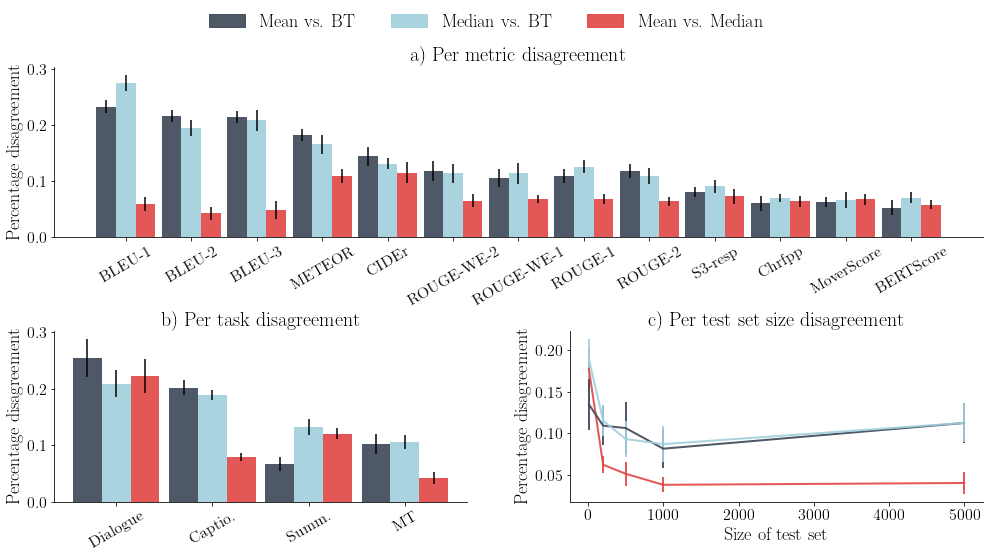

In [37]:
fig = plt.figure(constrained_layout=False, figsize=(30, 8))
gs = fig.add_gridspec(nrows=2, ncols=2, left=0.05, right=0.48, wspace=0.25)
ax2 = fig.add_subplot(gs[:-1, :])
ax1 = fig.add_subplot(gs[-1, :-1])
ax3 = fig.add_subplot(gs[-1, -1])


plot_task_impact(task_impact_dfs, ax1)
ax1.set_title('b) Per task disagreement')

plot_metric_impact(metric_impact_dfs, ax2, metrics_considered=metrics_considered)
ax2.set_title('a) Per metric disagreement')

plot_size_impact(impact_df, ax3)
ax3.set_title('c) Per test set size disagreement')

legend_elem = [
               mpatches.Patch(color=color_mean_bt, label='Mean vs. BT', alpha=0.9),
               mpatches.Patch(color=color_med_bt, label='Median vs. BT', alpha=0.9),
               mpatches.Patch(color=color_mean_med, label='Mean vs. Median', alpha=0.9)
]

fig.subplots_adjust(hspace=+.55)

# matplotlib.rc('xtick', labelsize=20) 
# matplotlib.rc('ytick', labelsize=20)

fig.legend(handles=legend_elem, ncol=3, loc='upper center', frameon=False, bbox_to_anchor=(0.25, 1.0))
fig.tight_layout(pad=1.1)
# fig.savefig("images-output/impact_all.pdf", bbox_inches="tight")

## View on Uncertainty

In [443]:
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order', 'xlabel', 'ylabel'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    
    valfmt = matplotlib.ticker.StrMethodFormatter("{x:.2f}")
    
    for x_, y_, v in zip(x, y, size):
        ax.text(x_to_num[x_] - 0.19, y_to_num[y_] - 0.07, s=valfmt(v), c='white')
#         print("{}, {}, {}".format(x_, y_, v))
        
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45)#, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
#     ax.set_facecolor('#F1F1F1')

    ax.set_xlabel(kwargs.get('xlabel', ''))
    ax.set_ylabel(kwargs.get('ylabel', ''))

    # Add color legend on the right side of the plot
#     if color_min < color_max:
#         ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

#         col_x = [0]*len(palette) # Fixed x coordinate for the bars
#         bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

#         bar_height = bar_y[1] - bar_y[0]
#         ax.barh(
#             y=bar_y,
#             width=[5]*len(palette), # Make bars 5 units wide
#             left=col_x, # Make bars start at 0
#             height=bar_height,
#             color=palette,
#             linewidth=0
#         )
#         ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
#         ax.grid(False) # Hide grid
#         ax.set_facecolor('white') # Make background white
#         ax.set_xticks([]) # Remove horizontal ticks
#         ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
#         ax.yaxis.tick_right() # Show vertical ticks on the right 

In [429]:
def pairwise_uncertainty_analysis(df, significant, threshold=0.05):
    for sys_a,sys_b in list(itertools.combinations(df.columns, 2)):
        scores_a = df[sys_a]
        scores_b = df[sys_b]
        
        ## Is mean significant
        s, pval_mean = stats.ttest_rel(scores_a, scores_b)
        ## Is median significant
        try:
            s, pval_median, _, _ = stats.median_test(scores_a, scores_b)
        except:
            pval_median = 1.
        
        ## Is Wilcoxon significant
        try:
            s, pval_wilcoxon = stats.wilcoxon(scores_a, scores_b)
        except:
            pval_wilcoxon = 1.
        
        ## Is BT significant
        bt_scores = BT(df[[sys_a, sys_b]])
        best_sys = (sys_a if bt_scores[0] >= bt_scores[1] else sys_b)
        worst_sys = (sys_b if bt_scores[0] >= bt_scores[1] else sys_a)
        res = (df[best_sys] - df[worst_sys]) > 0
        pval_bt = stats.binom_test(np.sum(res), n=len(res), p=0.5)
        
        
        significant['ttest'].append(int(pval_mean < threshold))
        significant['mood'].append(int(pval_median < threshold))
        significant['sign'].append(int(pval_bt < threshold))
        significant['wilcoxon'].append(int(pval_wilcoxon < threshold))
        
    
    return significant

def make_confusion_matrix(significant):
    conf_matrix = np.zeros((4,4))
    
    ## First line
    df_mean_sign = significant[significant['ttest'] == 1]
    conf_matrix[0][0] = significant.mean(axis=0)['ttest'] ## percentage of times ttest is significant
    conf_matrix[0][1] = df_mean_sign.mean(axis=0)['mood'] ## percentage of time mood is significant when ttest is
    conf_matrix[0][2] = df_mean_sign.mean(axis=0)['sign']
    conf_matrix[0][3] = df_mean_sign.mean(axis=0)['wilcoxon']
    
    ## First line
    df_median_sign = significant[significant['mood'] == 1]
    conf_matrix[1][1] = significant.mean(axis=0)['mood'] ## percentage of times mood is significant
    conf_matrix[1][0] = df_median_sign.mean(axis=0)['ttest'] ## percentage of time ttest is significant when mood is
    conf_matrix[1][2] = df_median_sign.mean(axis=0)['sign']
    conf_matrix[1][3] = df_median_sign.mean(axis=0)['wilcoxon']
    
    ## First line
    df_bt_sign = significant[significant['sign'] == 1]
    conf_matrix[2][2] = significant.mean(axis=0)['sign'] 
    conf_matrix[2][0] = df_bt_sign.mean(axis=0)['ttest']
    conf_matrix[2][1] = df_bt_sign.mean(axis=0)['mood']
    conf_matrix[2][3] = df_bt_sign.mean(axis=0)['wilcoxon']
    
    df_wilcoxon_sign = significant[significant['wilcoxon'] == 1]
    conf_matrix[3][3] = significant.mean(axis=0)['wilcoxon'] 
    conf_matrix[3][0] = df_wilcoxon_sign.mean(axis=0)['ttest']
    conf_matrix[3][1] = df_wilcoxon_sign.mean(axis=0)['mood']
    conf_matrix[3][2] = df_wilcoxon_sign.mean(axis=0)['sign']
    
    return conf_matrix

def uncertainty_analysis(datasets, repeat=1000):
    
    significant = defaultdict(list)
    nb = 0
    for _ in range(repeat):
        dataset_key = random.choice(list(datasets.keys()))
        dataset = datasets[dataset_key]
            
        metric_name = random.choice(list(dataset.keys()))
        df = dataset[metric_name].sample(frac=0.2)
        

        significant = pairwise_uncertainty_analysis(df, significant)
            
    return make_confusion_matrix(pd.DataFrame.from_dict(significant))

In [430]:
conf_matrix = uncertainty_analysis(merged_datasets)

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/more

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small f

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small f

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/more

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/more

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small f

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/more

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/more

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/more

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small f

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/more

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/more

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/more

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small f

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/more

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/more

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/more

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/more

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/more

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/more

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/more

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/more

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/more

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small f

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/more

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/more

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/more

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/more

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/more

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small f

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/more

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small f

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small f

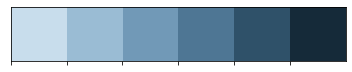

In [555]:
sns.palplot(sns.cubehelix_palette(start=125.67, rot=.0))

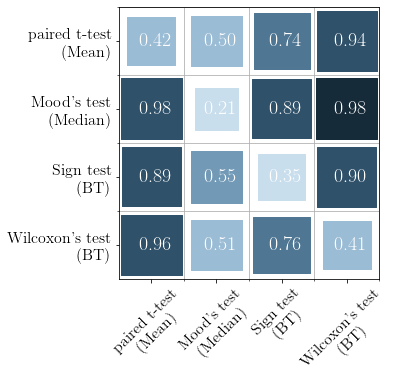

In [445]:
labels = ['paired t-test \n (Mean)', 'Mood\'s test \n (Median)', 'Sign test \n (BT)', 'Wilcoxon\'s test \n (BT)']
short_labels = ['Paired t-test', 'Mood\'s test', 'Sign test', 'Wilcoxon\'s test']
col_i, col_j, val = [], [], []
for i, lab_i in enumerate(labels):
    for j, lab_j in enumerate(labels):
        col_i.append(lab_i)
        col_j.append(lab_j)
        val.append(conf_matrix[i][j])
conf_matrix_df = pd.DataFrame.from_dict({'agg_i': col_i, 'agg_j': col_j, 'val':val})    

plt.figure(figsize=(5, 5))

heatmap(
    x=conf_matrix_df['agg_j'], # Column to use as horizontal dimension 
    y=conf_matrix_df['agg_i'], # Column to use as vertical dimension
    
    size_scale=5000, # Change this to see how it affects the plot
    size=conf_matrix_df['val'], # Values to map to size, here we use number of items in each bucket
    
    x_order=labels, # Sort order for x labels
    y_order=labels[::-1], # Sort order for y labels
    color=conf_matrix_df['val'], # Values to map to color, here we use number of items in each bucket
    palette=sns.cubehelix_palette(start=8.67, rot=.0), # We'll use black->red palette
    
    size_range=[-0.5, 1.5]
)
plt.savefig("images-output/uncertainty.pdf", bbox_inches="tight")